In [1]:
# Import the essential libraries

import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib as mpl

from numpy.linalg import svd, eig, norm
from scipy.linalg import subspace_angles

### Verifying the three–square asymptotics numerically

In this section we test the analytic estimate
\begin{align}
|\mathcal R(X)| \;\sim\; \frac{5}{6}X + \eta \log X + \dots,
\end{align}
for the number of integers $n \le X$ that can be written as a sum of three squares,
\begin{align}
n = x^2 + y^2 + z^2, \qquad x,y,z \in \mathbb Z.
\end{align}

In the main text we distinguish two related counting problems:

1. **Unbounded three–square count.**  
   This is the ideal Legendre–Gauss problem. We define
   \begin{align}
   \mathcal R(X)
   := \{\, n \le X : n = x^2 + y^2 + z^2 \text{ for some } x,y,z \in \mathbb Z \,\}.
   \end{align}
   For $X = R^2$, any solution must satisfy $|x|,|y|,|z|\le R$, so it is enough
   to scan the finite box $[0,R]^3$ when we only care about the squared values.
   The function `generate_three_square_sums(R)` uses this observation: it loops
   over all triples of squares
   \begin{align}
   0 \le x^2, y^2, z^2 \le R^2,
   \end{align}
   records which integers $m = x^2 + y^2 + z^2$ with $m \le R^2$ occur, and
   returns the number of distinct values. This gives a brute–force numerical
   estimate of $|\mathcal R(X)|$ with $X = R^2$.

2. **Bounded grid (Fourier lattice) count.**  
   On the finite Fourier grid used in the field theory, the allowed momentum
   labels are integer triplets
   \begin{align}
   (n_1,n_2,n_3) \in [-R,R]^3,
   \end{align}
   further restricted by a spherical UV cutoff $n_1^2 + n_2^2 + n_3^2 \le R^2$.
   The corresponding set of squared radii is
   \begin{align}
   \mathcal K(X)
   := \{\, n_1^2 + n_2^2 + n_3^2 \le X : n_i \in [-R,R]\cap\mathbb Z \,\},
   \qquad X = R^2.
   \end{align}
   The function `generate_grid_sums(R)` implements this bounded problem by
   looping over all integer triples in $[-R,R]^3$, computing
   $m = n_1^2 + n_2^2 + n_3^2$, and counting how many distinct values
   $m \le R^2$ occur. This is the quantity denoted $|\mathcal K(X)|$ in the text.

Both functions maintain a boolean array `seen[0..R^2]`, where `seen[m]` is set to
`True` if there exists at least one triple with sum of squares equal to $m$.
The final count is simply the number of `True` entries.

We then scan a range of radii
\begin{align}
R \in \{2000, 2400, \dots, 17200\},
\end{align}
compute the three–square count `Three_squares_R = |𝓡(R^2)|`, and compare it
against the analytic prediction
\begin{align}
|\mathcal R(X)|_{\text{theory}}
= \frac{5}{6} X + \eta \log X,
\qquad
X = R^2,
\end{align}
with $\eta$ treated as a fitted coefficient controlling the subleading
logarithmic term. The first subplot shows the raw counts versus the analytic
curve; the second subplot shows the relative residual
\begin{align}
\frac{|\mathcal R(R^2)| - |\mathcal R(R^2)|_{\text{theory}}}
     {|\mathcal R(R^2)|},
\end{align}
illustrating the quality of the asymptotic approximation in the range relevant
for our field–theory discretisation.

The bounded grid count $|\mathcal K(X)|$ is stored alongside and used elsewhere
to show that the finite Fourier lattice converges monotonically to the ideal
three–square count as $R$ increases.


In [ ]:
@njit(parallel=True)
def generate_grid_sums(R):
    """
    Count unique sums of three squares n1^2 + n2^2 + n3^2
    for integer triplets (n1,n2,n3) ∈ [-R, R]^3
    with n1^2 + n2^2 + n3^2 ≤ R^2.

    This corresponds to the bounded (grid) set 𝓚 with X = R^2.
    """
    max_val = R * R              
    seen = np.zeros(max_val + 1, dtype=np.bool_)
    squares = np.arange(-R, R + 1)**2

    for i in prange(squares.size):
        x2 = squares[i]
        for j in range(squares.size):
            y2 = squares[j]
            xy2 = x2 + y2
            if xy2 > max_val:
                continue
            for k in range(squares.size):
                z2 = squares[k]
                m = xy2 + z2
                if m <= max_val:
                    seen[m] = True
    return np.count_nonzero(seen)


@njit(parallel=True)
def generate_three_square_sums(R):
    """
    Count all integers representable as x^2 + y^2 + z^2 ≤ R^2
    for x,y,z ∈ ℤ.

    By the basic bound |x|,|y|,|z| ≤ √(R^2) = R, it suffices to scan 0..R.
    """
    max_val = R * R              
    seen = np.zeros(max_val + 1, dtype=np.bool_)
    bound = int(np.sqrt(max_val))   # = R
    squares = np.arange(0, bound + 1)**2

    for i in prange(squares.size):
        x2 = squares[i]
        for j in range(squares.size):
            y2 = squares[j]
            xy2 = x2 + y2
            if xy2 > max_val:
                continue
            for k in range(squares.size):
                z2 = squares[k]
                m = xy2 + z2
                if m <= max_val:
                    seen[m] = True
    return np.count_nonzero(seen)

'NOTE: Data generation takes time!'

R_values = np.arange(2000, 20000 + 1, 400)  # <--- you can go higher, it just takes more time :-)
Uniq_freq_grid = np.zeros(len(R_values), dtype=np.int64)
Three_squares_R = np.zeros(len(R_values), dtype=np.int64)

for idx, R in enumerate(R_values):
    Uniq_freq_grid[idx] = generate_grid_sums(R)
    Three_squares_R[idx] = generate_three_square_sums(R)
    np.save('data/Uniq_freq_grid.npy', Uniq_freq_grid[:idx+1])
    np.save('data/Three_squares_R.npy', Three_squares_R[:idx+1])
    np.save('data/R_values.npy', R_values[:idx+1])


    print(f"\rComputed R={R}, done ({idx+1}/{len(R_values)})", end="")
    



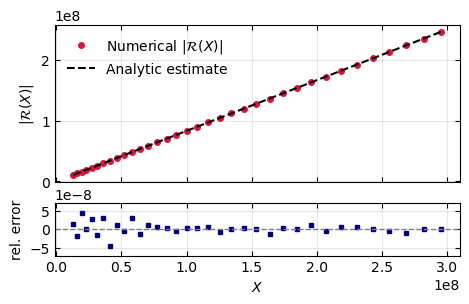

In [2]:

R_values  = np.load('data/R_values.npy')
Three_squares_R = np.load('data/Three_squares_R.npy')

eta = 0.37  
X_vals =  R_values**2
Theory = (5/6) * X_vals + eta * np.log(X_vals/7) / np.log(4)



# -----------------------------------------------------
# Plot: three–square counts vs theory + residuals
# -----------------------------------------------------


residuals = (Three_squares_R - Theory) / Three_squares_R

# ----------------------------
# Figure geometry
# ----------------------------
pdftxtwidt = 6.17
figwidth   = 0.80 * pdftxtwidt
figheight  = 0.60 * figwidth

fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(figwidth, figheight),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# ----------------------------
# Top panel: counts
# ----------------------------
ax1.plot(
    R_values[4:]**2, Three_squares_R[4:],
    "o", color="crimson", markersize=4,
    label=r"Numerical $|\mathcal{R}(X)|$"
)
ax1.plot(
    R_values[4:]**2, Theory[4:],
    "--", color="black", linewidth=1.5,
    label=r"Analytic estimate"
)

ax1.set_ylabel(r"$|\mathcal{R}(X)|$")
ax1.legend(frameon=False, loc="upper left")
ax1.grid(True, alpha=0.3)

# ------------------------------------------
# Bottom panel: relative error
# ------------------------------------------

ax2.plot(
    R_values[4:]**2, residuals[4:],
    "s", color="navy", markersize=3
)
ax2.axhline(0.0, color="gray", linestyle="--", linewidth=1)

ax2.set_xlabel(r"$X$")


ticks = np.array([ -5e-8, 0.0, 5e-8])
ax2.set_yticks(ticks)


ax2.set_ylabel("rel. error")

# keep the y–range tight around our ticks
pad = 0.2 * (ticks.max() - ticks.min())
ax2.set_ylim(ticks.min() - pad, ticks.max() + pad)

ax2.grid(True, alpha=0.3)

# ----------------------------
# General styling
# ----------------------------
for ax in (ax1, ax2):
    ax.tick_params(direction="in", top=True, right=True)

fig.subplots_adjust(
    left=0.16,
    right=0.98,
    bottom=0.16,
    top=0.94,
    hspace=0.2,
)

fig.savefig("figures/freq_legendre_verification.pdf", dpi=300)
plt.show()


### Results and Interpretation

1. The ratio $ |\mathcal{K}| / |\mathcal{R}| $ approaches unity as $ R \to \infty $,
   confirming that the bounded grid faithfully approximates the unbounded integer set
   defined by the three-square theorem.

2. The asymptotic expression
   $|\mathcal{R}(X)| \approx \tfrac{5X}{6} + \eta \log_4(X/7)$
   matches the numerical data with relative deviations below $10^{-8}$,
   validating the asymptotic expression derived in the main text.

These results confirm that the number of distinct frequency shells
indeed scales linearly with the area, up to logarithmic corrections.


# 1. Free-Field Validation: Independence from Initial Conditions

We first consider the free scalar field ($\lambda=0$) and test the universality
of the projection error drop across several random initial conditions.

For each realization of $(\mathbf{Q}(0), \mathbf{P}(0))$, we build the complex snapshot matrix
\begin{align}
\mathbb{X}_s = Q_\alpha(t_j) + i\,P_\alpha(t_j),
\end{align}
and compute the relative projection error
\begin{align}
\mathcal{E}_{\mathrm{proj}}(r)
= \frac{\|\mathbb{X}_s - \mathbf{V}_r\mathbf{V}_r^+\mathbb{X}_s\|_F}
       {\|\mathbb{X}_s\|_F}.
\end{align}

Theory predicts that for the free field the error vanishes precisely when
the reduced dimension reaches $2r = 4n_\Omega$,
independently of the chosen initial amplitudes and phases.


In [3]:
# =============================================================
# Stage 1 — Generate and save free-field projection error data
# =============================================================


# --- Parameters ---
L, N, m, T_factor = 20.0, 14, 1.0, 14.0
T_max, save_stride = T_factor*L, 25
n_ic = 3               # number of initial condition samples
scale_ic = 0.01
seed_ic = 123
safety_linear = 0.2

# --- Grid setup ---
a = L / N
kx = 2*np.pi*np.fft.fftfreq(N, d=a)
ky = 2*np.pi*np.fft.fftfreq(N, d=a)
kz = 2*np.pi*np.fft.rfftfreq(N, d=a)
# KX, KY, KZ = np.meshgrid(kx, ky, kz)
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')

k2 = KX**2 + KY**2 + KZ**2 

# --- FFT helpers ---
def rfftn3(u): return np.fft.rfftn(u, axes=(0,1,2))
def irfftn3(uk): return np.fft.irfftn(uk, s=(N,N,N), axes=(0,1,2))
def minus_laplacian(u): return irfftn3(-k2 * rfftn3(u))
def gradV_free(q): return (m*m)*q - minus_laplacian(q)

# --- Time parameters ---
omega_lin = np.sqrt(m*m + k2.max())
# dt = 0.2 / omega_lin
# steps = int(T_max / dt)
# t_len_save = (steps + save_stride - 1)//save_stride
Nsites = N**3

dt0 = safety_linear / omega_lin

steps = int(np.ceil(T_max / dt0))
dt = T_max / steps

# NEW: choose save_stride to keep enough snapshots for SVD
target_saves = 800
save_stride = max(1, steps // target_saves)
t_len_save = (steps + save_stride - 1) // save_stride

print(f"[time] T_max={T_max:.3f} ~ {T_factor} L, steps={steps}, dt={dt:.3e}, saves={t_len_save}")

rng = np.random.default_rng(seed_ic)

def sample_vacuum_ic_real_space(N, L, m, rng, overall_scale=1.0):
    """
    Sample initial conditions q(x), p(x) whose Fourier modes mimic
    free quantum vacuum fluctuations (ħ=1):
        Var[q_k] = 1/(2 Ω_k),  Var[p_k] = Ω_k/2,
    with Ω_k = sqrt(m^2 + k^2).

    Returns:
        q, p : real arrays of shape (N,N,N)

    Notes:
    - Sampling is performed in Fourier space and then inverse FFT'd.
    - overall_scale lets you dial the amplitude up/down (e.g. 0.1, 1.0, 3.0).
    - Uses unitary FFT normalization ("ortho") so Parseval is clean.
    """

    a = L / N
    kx = 2*np.pi*np.fft.fftfreq(N, d=a)
    ky = 2*np.pi*np.fft.fftfreq(N, d=a)
    kz = 2*np.pi*np.fft.fftfreq(N, d=a)
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="ij")
    k2 = KX**2 + KY**2 + KZ**2
    Om = np.sqrt(m*m + k2)  # Ω_k

    # Target standard deviations per mode (ħ=1)
    sigma_q = overall_scale * np.sqrt(1.0 / (2.0 * Om))
    sigma_p = overall_scale * np.sqrt(Om / 2.0)

    # We sample in rFFT space for real fields: shape (N, N, N//2+1)
    kz_r = 2*np.pi*np.fft.rfftfreq(N, d=a)
    KXr, KYr, KZr = np.meshgrid(kx, ky, kz_r, indexing="ij")
    k2r = KXr**2 + KYr**2 + KZr**2
    Omr = np.sqrt(m*m + k2r)

    sigma_qr = overall_scale * np.sqrt(1.0 / (2.0 * Omr))
    sigma_pr = overall_scale * np.sqrt(Omr / 2.0)

    # Complex Gaussian helper: if z = (n1 + i n2)/sqrt(2), then Var(Re z)=Var(Im z)=1/2
    def complex_gaussian(shape):
        return (rng.standard_normal(shape) + 1j*rng.standard_normal(shape)) / np.sqrt(2.0)

    qk = sigma_qr * complex_gaussian((N, N, N//2 + 1))
    pk = sigma_pr * complex_gaussian((N, N, N//2 + 1))

    # Enforce "self-conjugate" rFFT modes to be purely real:
    # These are where the partner mode is itself: kz=0 and (if even N) kz=Nyquist,
    # also kx,ky at 0/Nyquist combinations. For simplicity: force purely real
    # at kz index 0 and - (Nyquist) index if exists.
    qk[:, :, 0] = np.real(qk[:, :, 0]) + 0j
    pk[:, :, 0] = np.real(pk[:, :, 0]) + 0j
    if (N % 2) == 0:
        qk[:, :, -1] = np.real(qk[:, :, -1]) + 0j
        pk[:, :, -1] = np.real(pk[:, :, -1]) + 0j

    # Inverse rFFT back to real space (unitary normalization)
    q = np.fft.irfftn(qk, s=(N, N, N), axes=(0,1,2), norm="ortho")
    p = np.fft.irfftn(pk, s=(N, N, N), axes=(0,1,2), norm="ortho")

    # Safety: ensure real (numerical tiny imag parts can appear)
    q = np.real(q)
    p = np.real(p)
    return q, p

overall_scale = 1.0

def run_sim(ic_seed):
    # q, p = sample_vacuum_ic_real_space(N, L, m, rng, overall_scale=overall_scale)
    q = scale_ic * rng.standard_normal((N,N,N))
    p = scale_ic * rng.standard_normal((N,N,N))
    X = np.empty((Nsites, t_len_save), dtype=np.complex128)
    save_j = 0
    for n in range(steps):
        p -= 0.5*dt * gradV_free(q)
        q += dt * p
        p -= 0.5*dt * gradV_free(q)
        if n % save_stride == 0 and save_j < t_len_save:
            X[:, save_j] = q.ravel() + 1j*p.ravel()
            save_j += 1
    return X

# --- Compute relative projection error ---
def rel_proj_error(X):
    G = X.conj().T @ X
    G = 0.5*(G + G.conj().T)
    w, _ = np.linalg.eigh(G)
    w = np.sort(np.clip(w.real, 0, None))[::-1]
    S = np.sqrt(w)
    S2 = S**2
    tail = np.cumsum(S2[::-1])[::-1]
    return np.sqrt(tail / (S2.sum() + 1e-300))

# --- Run and save ---
rel_errors = [rel_proj_error(run_sim(i)) for i in range(n_ic)]

np.savez("data/freefield_projection_errors.npz", **{f"IC_{i+1}": rel_errors[i] for i in range(n_ic)})
print("Projection error data saved to freefield_projection_errors.npz")


[time] T_max=280.000 ~ 14.0 L, steps=5514, dt=5.078e-02, saves=919
Projection error data saved to freefield_projection_errors.npz


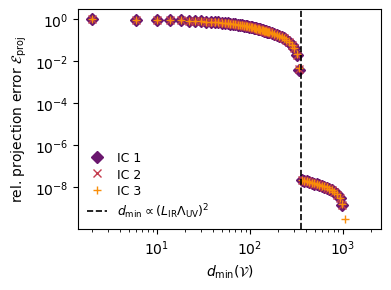

In [10]:
# ======================================================
# Stage 2 — Load and plot precomputed free-field data
# ======================================================


# --- Load data ---
data = np.load("data/freefield_projection_errors.npz", allow_pickle=True)
ics = list(data.keys())  # e.g. ["IC_1", "IC_2", "IC_3"]

# --- Parameters for theory line ---
L, N, m, T_max = 20.0, 14, 1.0, T_factor*L
a = L / N

def unique_omegas(N, a, m, T_max):
    k = 2*np.pi*np.fft.fftfreq(N, d=a)
    KX, KY, KZ = np.meshgrid(k, k, k, indexing="ij")
    w = np.sqrt(m*m + (KX**2 + KY**2 + KZ**2)).ravel()
    w.sort()
    tol = np.pi / T_max
    uniq = [w[0]]
    for x in w[1:]:
        if x - uniq[-1] > tol:
            uniq.append(x)
    return len(uniq)

n_omega = unique_omegas(N, a, m, T_max)
d_theory = 4 * n_omega

# --- Nonuniform sampling for smooth trend ---
def representative_indices(n):
    """Representative sample indices: dense at small ranks, sparse at large."""
    n_dense = min(80, n)
    dense_part = np.arange(0, n_dense, 2)
    sparse_part = np.unique(
        np.logspace(np.log10(max(n_dense, 2)), np.log10(n - 1), 40, dtype=int)
    )
    idxs = np.unique(np.concatenate([dense_part, sparse_part]))
    idxs = idxs[idxs < n]  # ensure all valid
    return idxs

# --- Plot ---
colors = colormaps.get_cmap('inferno')(np.linspace(0.3, 0.75, len(ics)))
markers = ['D', 'x', '+']

pdftxtwidt = 6.17
figwidth = 0.65 * pdftxtwidt
figheight = 0.75 * figwidth

plt.figure(figsize=(figwidth, figheight))
for i, key in enumerate(ics):
    rel = data[key]
    r_vals = np.arange(1, len(rel) + 1)
    reduced_dim = 2 * r_vals
    idxs = representative_indices(len(rel))
    plt.semilogy(reduced_dim[idxs], rel[idxs],
                 marker=markers[i % len(markers)],
                 color=colors[i],
                 markersize=6,
                 linestyle='None',
                 label=f'IC {i+1}')

# Theory line 
plt.axvline(
    d_theory,
    color='k',
    ls='--',
    lw=1.2,
    label=r'$d_{\rm min} \propto (L_{\rm IR}\Lambda_{\rm UV})^{2}$'
)

plt.xscale('log')
plt.xlabel(r'$d_{\rm min}(\mathcal{V})$')
plt.ylabel(r'rel. projection error $\mathcal{E}_{\mathrm{proj}}$')

plt.legend(
    frameon=False,
    fontsize=9,
    loc='lower left',
    handlelength=1.6,
    borderpad=0.2,
    labelspacing=0.3
)

plt.tight_layout()
plt.savefig("figures/projection_error_freefield_multiIC_final.pdf",
            dpi=400, bbox_inches='tight')
plt.show()



# 2. Robustness under Weak Quartic Self-Interaction

Next, we add a weak self-interaction
\begin{align}
\mathcal{H}_\lambda = \frac{1}{2}\,P^2 + \frac{1}{2}\,\Omega^2 Q^2 + \frac{\lambda}{4}\phi^4,
\end{align}
and study how the projection error $\mathcal{E}_{\mathrm{proj}}$ evolves
with increasing coupling $\lambda$.

For small $\lambda$, Kolmogorov–Arnold–Moser (KAM) and Nekhoroshev theory
predict that the effective number of independent frequencies—and thus
the reduced rank—remains nearly unchanged, leading to a stable
“cliff” in the error curve at the same threshold.


In [5]:
# ------------------------------
# Simulation parameters
# ------------------------------
L = 20.0
N = 14
m = 1.0

lams = [0.0, 1e-6, 1e-4, 1e-2]   # NEW

scale_ic = 0.01

# NEW: short runtime ~ O(1) light-crossing
T_factor = 14.0
T_max = T_factor * L

# safer for strong coupling
safety_linear = 0.2
safety_nl = 0.05   # NEW (tighter for λ=1)

seed_ic = 42
rng = np.random.default_rng(seed_ic)

# ------------------------------
# Derived quantities
# ------------------------------
a = L / N
kx = 2 * np.pi * np.fft.fftfreq(N, d=a)
ky = 2 * np.pi * np.fft.fftfreq(N, d=a)
kz = 2 * np.pi * np.fft.rfftfreq(N, d=a)
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="ij")
k2 = KX**2 + KY**2 + KZ**2
Nsites = N**3

# ------------------------------
# Stable timestep (safe for all λ)
# ------------------------------
omega_lin = np.sqrt(m * m + k2.max())
phi_rms = 2.0 * scale_ic
omega_eff_each = np.sqrt(m * m + k2.max() + 3.0 * np.array(lams) * (phi_rms ** 2))
omega_eff = max(omega_lin, np.max(omega_eff_each))
dt0 = min(safety_linear / omega_lin, safety_nl / omega_eff)

steps = int(np.ceil(T_max / dt0))
dt = T_max / steps

# NEW: choose save_stride to keep enough snapshots for SVD
target_saves = 800
save_stride = max(1, steps // target_saves)
t_len_save = (steps + save_stride - 1) // save_stride

print(f"[time] T_max={T_max:.3f} ~ {T_factor} L, steps={steps}, dt={dt:.3e}, saves={t_len_save}")


[time] T_max=280.000 ~ 14.0 L, steps=22054, dt=1.270e-02, saves=817


In [6]:
"""
Generate complex snapshot matrices X_c(λ) for the 3D φ⁴ field
and save them as phi4_snapshots.npz for later analysis.

CPU version (NumPy only), intended for reproducibility in future studies.

Each snapshot matrix corresponds to one coupling λ
and has shape (N^3, Tsave), with entries Q + i P.
"""


# ------------------------------
# Simulation parameters
# ------------------------------
L = 20.0
N = 14
m = 1.0

# lams = [0.0, 1e-2, 1e-1, 1.0]   # NEW
lams  = [0.0, 1e-6, 1e-4, 1e-2]
scale_ic = 0.01

# NEW: short runtime ~ O(1) light-crossing
# T_factor = 12.0
# T_max = T_factor * L

# safer for strong coupling
safety_linear = 0.2
safety_nl = 0.05   # NEW (tighter for λ=1)

seed_ic = 2
rng = np.random.default_rng(seed_ic)

# ------------------------------
# Derived quantities
# ------------------------------
a = L / N
kx = 2 * np.pi * np.fft.fftfreq(N, d=a)
ky = 2 * np.pi * np.fft.fftfreq(N, d=a)
kz = 2 * np.pi * np.fft.rfftfreq(N, d=a)
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="ij")
k2 = KX**2 + KY**2 + KZ**2
Nsites = N**3



# --- FFT helpers ---
def rfftn3(u):
    return np.fft.rfftn(u, axes=(0, 1, 2))

def irfftn3(uk):
    return np.fft.irfftn(uk, s=(N, N, N), axes=(0, 1, 2))

def minus_laplacian(u):
    """Compute −Δu using spectral differentiation."""
    return irfftn3(-k2 * rfftn3(u))

# ------------------------------
# Forces (gradients of potential)
# ------------------------------
def gradV_free(q):
    """Linear (free) potential gradient: (m^2 - Δ) q."""
    return (m * m) * q - minus_laplacian(q)

def gradV_interacting(q, lam):
    """Full gradient including φ⁴ term: (m^2 - Δ) q + λ q³."""
    return gradV_free(q) + lam * (q ** 3)

# -------------------------------------
# Stable timestep (safe for all λ) (NEW)
# -------------------------------------
omega_lin = np.sqrt(m * m + k2.max())
phi_rms = 2.0 * scale_ic
omega_eff_each = np.sqrt(m * m + k2.max() + 3.0 * np.array(lams) * (phi_rms ** 2))
omega_eff = max(omega_lin, np.max(omega_eff_each))
dt0 = min(safety_linear / omega_lin, safety_nl / omega_eff)

steps = int(np.ceil(T_max / dt0))
dt = T_max / steps

# NEW: choose save_stride to keep enough snapshots for SVD
target_saves = 800
save_stride = max(1, steps // target_saves)
t_len_save = (steps + save_stride - 1) // save_stride

print(f"[time] T_max={T_max:.3f} ~ {T_factor} L, steps={steps}, dt={dt:.3e}, saves={t_len_save}")




def sample_vacuum_ic_real_space(N, L, m, rng, overall_scale=1.0):
    """
    Sample initial conditions q(x), p(x) whose Fourier modes mimic
    free quantum vacuum fluctuations (ħ=1):
        Var[q_k] = 1/(2 Ω_k),  Var[p_k] = Ω_k/2,
    with Ω_k = sqrt(m^2 + k^2).

    Returns:
        q, p : real arrays of shape (N,N,N)

    Notes:
    - Sampling is performed in Fourier space and then inverse FFT'd.
    - overall_scale lets you dial the amplitude up/down (e.g. 0.1, 1.0, 3.0).
    - Uses unitary FFT normalization ("ortho") so Parseval is clean.
    """

    a = L / N
    kx = 2*np.pi*np.fft.fftfreq(N, d=a)
    ky = 2*np.pi*np.fft.fftfreq(N, d=a)
    kz = 2*np.pi*np.fft.fftfreq(N, d=a)
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="ij")
    k2 = KX**2 + KY**2 + KZ**2
    Om = np.sqrt(m*m + k2)  # Ω_k

    # Target standard deviations per mode (ħ=1)
    sigma_q = overall_scale * np.sqrt(1.0 / (2.0 * Om))
    sigma_p = overall_scale * np.sqrt(Om / 2.0)

    # We sample in rFFT space for real fields: shape (N, N, N//2+1)
    kz_r = 2*np.pi*np.fft.rfftfreq(N, d=a)
    KXr, KYr, KZr = np.meshgrid(kx, ky, kz_r, indexing="ij")
    k2r = KXr**2 + KYr**2 + KZr**2
    Omr = np.sqrt(m*m + k2r)

    sigma_qr = overall_scale * np.sqrt(1.0 / (2.0 * Omr))
    sigma_pr = overall_scale * np.sqrt(Omr / 2.0)

    # Complex Gaussian helper: if z = (n1 + i n2)/sqrt(2), then Var(Re z)=Var(Im z)=1/2
    def complex_gaussian(shape):
        return (rng.standard_normal(shape) + 1j*rng.standard_normal(shape)) / np.sqrt(2.0)

    qk = sigma_qr * complex_gaussian((N, N, N//2 + 1))
    pk = sigma_pr * complex_gaussian((N, N, N//2 + 1))

    # Enforce "self-conjugate" rFFT modes to be purely real:
    # These are where the partner mode is itself: kz=0 and (if even N) kz=Nyquist,
    # also kx,ky at 0/Nyquist combinations. For simplicity: force purely real
    # at kz index 0 and - (Nyquist) index if exists.
    qk[:, :, 0] = np.real(qk[:, :, 0]) + 0j
    pk[:, :, 0] = np.real(pk[:, :, 0]) + 0j
    if (N % 2) == 0:
        qk[:, :, -1] = np.real(qk[:, :, -1]) + 0j
        pk[:, :, -1] = np.real(pk[:, :, -1]) + 0j

    # Inverse rFFT back to real space (unitary normalization)
    q = np.fft.irfftn(qk, s=(N, N, N), axes=(0,1,2), norm="ortho")
    p = np.fft.irfftn(pk, s=(N, N, N), axes=(0,1,2), norm="ortho")

    # Safety: ensure real (numerical tiny imag parts can appear)
    q = np.real(q)
    p = np.real(p)
    return q, p

overall_scale = 1.0
# ------------------------------
# Time integration (Velocity–Verlet)
# ------------------------------
def evolve_phi4(lam):
    """Evolve φ⁴ field with coupling λ and return snapshot matrix."""
    q, p = sample_vacuum_ic_real_space(N, L, m, rng, overall_scale=overall_scale)
    # q = scale_ic * rng.standard_normal((N, N, N))
    # p = scale_ic * rng.standard_normal((N, N, N))
    X = np.empty((Nsites, t_len_save), dtype=np.complex128)
    save_j = 0

    for n in range(steps):
        # Half-step momentum update
        p -= 0.5 * dt * gradV_interacting(q, lam)
        # Position update
        q += dt * p
        # Half-step momentum update again
        p -= 0.5 * dt * gradV_interacting(q, lam)

        # Save snapshot every 'save_stride' steps
        if n % save_stride == 0 and save_j < t_len_save:
            X[:, save_j] = q.ravel() + 1j * p.ravel()
            save_j += 1

    return X[:, :save_j]

# ------------------------------
# Run for all λ and save
# ------------------------------
out = {}
for lam in lams:
    print(f"[run] λ={lam:g}")
    out[f"lam_{lam}"] = evolve_phi4(lam)

np.savez("data/phi4_snapshots.npz", **out)
print("Saved snapshot dataset: phi4_snapshots.npz")

# Also save metadata:
meta = {
    "L": L, "N": N, "m": m,
    "dt": float(dt), "save_stride": int(save_stride),
    "T_max": T_max, "steps": int(steps),
    "lams": np.array(lams, dtype=float)
}
np.savez("data/phi4_meta.npz", **meta)
print("Saved meta: phi4_meta.npz")



[time] T_max=280.000 ~ 14.0 L, steps=22054, dt=1.270e-02, saves=817
[run] λ=0
[run] λ=1e-06
[run] λ=0.0001
[run] λ=0.01
Saved snapshot dataset: phi4_snapshots.npz
Saved meta: phi4_meta.npz


In [7]:
# ===============================================
# Compute and save relative projection error data
# ===============================================

# --- Load raw snapshot data ---
data = np.load("data/phi4_snapshots.npz", allow_pickle=True)
lams = [0.0, 1e-6, 1e-4, 1e-2]
# lams = [0.0, 1e-2, 1e-1, 1.0]   # NEW

# --- Helper: relative projection error from snapshot matrix ---
def rel_proj_error(X):
    G = X.conj().T @ X
    G = 0.5 * (G + G.conj().T)
    w, _ = np.linalg.eigh(G)
    w = np.sort(np.clip(w.real, 0, None))[::-1]
    S = np.sqrt(w)
    S2 = S**2
    tot = S2.sum()
    tail = np.cumsum(S2[::-1])[::-1]
    return np.sqrt(tail / tot)

# --- Compute & store results ---
proj_errors = {}
for lam in lams:
    X = data[f"lam_{lam}"]
    proj_errors[str(lam)] = rel_proj_error(X)

# Save to npz for plotting later
np.savez("data/phi4_projection_errors.npz", **proj_errors)
print("Saved projection error data to 'phi4_projection_errors.npz'")


Saved projection error data to 'phi4_projection_errors.npz'


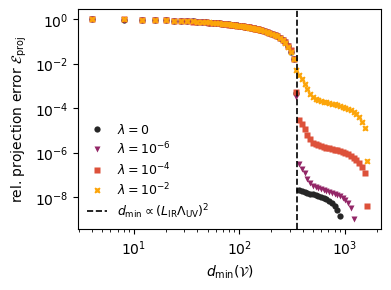

In [9]:

# --- Load precomputed errors ---
errors = np.load("data/phi4_projection_errors.npz", allow_pickle=True)
lams = [0.0, 1e-6, 1e-4, 1e-2]
# lams = [0.0, 1e-2, 1e-1, 1.0]   # NEW

# --- Theoretical cutoff ---
def unique_omegas(N, a, m, T_max):
    k = 2*np.pi*np.fft.fftfreq(N, d=a)
    KX, KY, KZ = np.meshgrid(k, k, k, indexing="ij")
    w = np.sqrt(m*m + (KX**2 + KY**2 + KZ**2)).ravel()
    w.sort()
    tol = np.pi / T_max  # In general, this is defined up to O(1)/T_max.
    uniq = [w[0]]
    for x in w[1:]:
        if x - uniq[-1] > tol:
            uniq.append(x)
    return len(uniq)

# L, N, m, T_max = 20.0, 14, 1.0, T_factor*L #9000.0
# a = L / N
n_omega = unique_omegas(N, a, m, T_max)
d_theory = 4 * n_omega

# --- Sampling for clean plot ---
def representative_indices(n):
    n_dense = min(80, n)
    dense_part = np.arange(1, n_dense, 2)
    sparse_part = np.unique(np.logspace(np.log10(n_dense),
                                        np.log10(n - 1), 40, dtype=int))
    return np.unique(np.concatenate([dense_part, sparse_part]))

# --- Colours / markers ---
cmap = colormaps.get_cmap('inferno')
colors = [
    (0.15, 0.15, 0.15, 1.0),  # λ = 0 → dark grey
    cmap(0.40),               # λ = 10^-6
    cmap(0.60),               # λ = 10^-4
    cmap(0.80),               # λ = 10^-2
]
markers = ['o', 'v', 's', 'X']

def format_lambda(lam):
    if lam == 0.0:
        return r'$\lambda = 0$'
    exp = int(np.round(np.log10(lam)))
    return rf'$\lambda = 10^{{{exp}}}$'

# --- Figure geometry ---
pdftxtwidt = 6.17
figwidth = 0.65 * pdftxtwidt
figheight = 0.75 * figwidth

plt.figure(figsize=(figwidth, figheight))

for i, lam in enumerate(lams):
    rel = errors[str(lam)]
    r_vals = np.arange(1, len(rel) + 1)
    reduced_dim = 2 * r_vals
    idxs = representative_indices(len(rel))

    plt.semilogy(
        reduced_dim[idxs], rel[idxs],
        marker=markers[i % len(markers)],
        color=colors[i],
        markersize=4.5,
        linestyle='None',
        markeredgecolor='none',
        label=format_lambda(lam)
    )

# vertical line + theory label
plt.axvline(
    d_theory, color='k', ls='--', lw=1.2,
    label=r'$d_{\rm min} \propto (L_{\rm IR}\Lambda_{\rm UV})^{2}$'
)

plt.xscale('log')
plt.xlabel(r'$d_{\rm min}(\mathcal{V})$')
plt.ylabel(r'rel. projection error $\mathcal{E}_{\mathrm{proj}}$')

# Legend: smaller font, tucked in lower left so it doesn’t sit on the data
plt.legend(
    frameon=False,
    fontsize=9,
    loc='lower left',        # inside axes, bottom-left corner
    handlelength=1.6,
    borderpad=0.2,
    labelspacing=0.3
)

plt.tight_layout()
plt.savefig('figures/projection_error_lambda_sweep_final.pdf',
            dpi=300, bbox_inches='tight')
plt.show()


## Appendix diagnostic A — Weak-nonlinearity level $\varepsilon(t)$

To document that we remain in the weakly nonlinear (quasi-integrable) window, we
track

\begin{align}
\varepsilon(t)
&:= \frac{\lambda\int_{\mathcal B}\phi^4\,\mathrm d^3x}
           {P^2 + Q^{\top}\Omega^2 Q},
\end{align}

i.e. the quartic energy relative to the quadratic energy of the free theory.
We reconstruct $q(\cdot,t)$ and $p(\cdot,t)$ from snapshots, compute
$\int q(m^2-\Delta)q\,\mathrm d^3x$ spectrally, and plot $\varepsilon(t)$.

**Interpretation.** If $\varepsilon(t)\ll 1$ over $0\le t\le T_{\text{obs}}$,
we are in the regime where KAM/Nekhoroshev heuristics apply: frequencies are
only weakly renormalised and energy exchange between mode families is slow.


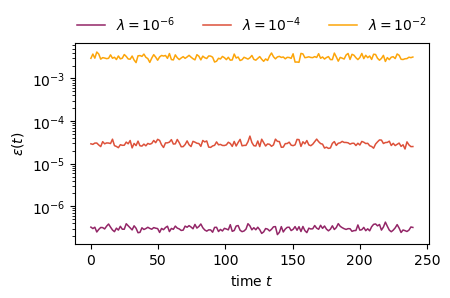

In [12]:

mpl.rcParams['text.usetex'] = False
mpl.rcParams['savefig.bbox'] = None   # <-- disable global 'tight' cropping


# ----------------------------
# Load metadata and snapshots
# ----------------------------
meta = np.load("data/phi4_meta.npz", allow_pickle=True)
L   = float(meta["L"])
N   = int(meta["N"])
m   = float(meta["m"])
dt  = float(meta["dt"])
save_stride = int(meta["save_stride"])
all_lams = np.array(meta["lams"], dtype=float)

# Skip lambda = 0
lams = np.array([lam for lam in all_lams if not np.isclose(lam, 0.0)])
if lams.size == 0:
    raise ValueError("No positive λ values found in meta file.")

data = np.load("data/phi4_snapshots.npz", allow_pickle=True)

# ----------------------------
# Grid and spectral helpers
# ----------------------------
a  = L / N
vol = a**3

kx = 2*np.pi*np.fft.fftfreq(N, d=a)
ky = 2*np.pi*np.fft.fftfreq(N, d=a)
kz = 2*np.pi*np.fft.rfftfreq(N, d=a)
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="ij")
k2 = KX**2 + KY**2 + KZ**2

def rfftn3(u):   return np.fft.rfftn(u, s=(N, N, N), axes=(0,1,2))
def irfftn3(uk): return np.fft.irfftn(uk, s=(N, N, N), axes=(0,1,2))

def minus_laplacian(u):
    """Compute -Δu spectrally."""
    return irfftn3(-k2 * rfftn3(u))

# ----------------------------
# ε(t) computation
# ----------------------------
def epsilon_time_series(X, lam):
    """
    X: (N^3, Tsave) with entries q + i p at lattice sites.
    ε(t) = [λ ∫ φ^4] / [∫ (P^2 + Q·(m^2 - Δ)·Q)] (discrete Riemann sum).
    """
    q = X.real.reshape(N, N, N, -1)
    p = X.imag.reshape(N, N, N, -1)
    Tsave = q.shape[-1]

    eps = np.empty(Tsave)
    for t in range(Tsave):
        q_t = q[..., t]
        p_t = p[..., t]
        quad  = (p_t**2 + q_t*(m*m*q_t + minus_laplacian(q_t))).sum() * vol
        quart = lam * (q_t**4).sum() * vol
        eps[t] = (quart / quad) if quad > 0 else np.nan
    return eps

# ----------------------------
# Plot ε(t) for λ > 0
# ----------------------------
pdftxtwidt = 6.17
figwidth  = 0.70 * pdftxtwidt
figheight = 0.75 * figwidth   # taller to separate bands better

fig, ax = plt.subplots(figsize=(figwidth, figheight), constrained_layout=False)

cmap = colormaps.get_cmap('inferno')
colors = [
    (0, 0.15, 0.15, 1.0),  # λ = 0 -->  dark grey
    cmap(0.40),               # λ = 10^-6
    cmap(0.60),               # λ = 10^-4
    cmap(0.80),               # λ = 10^-2
]
eps_max = []

for i, lam in enumerate(lams):
    key = f"lam_{lam:g}"
    if key not in data:
        matches = [k for k in data.files
                   if np.isclose(float(k.split('_')[1]), lam)]
        if not matches:
            raise KeyError(f"No snapshots for λ={lam:g}. Available: {list(data.files)}")
        key = matches[0]

    X = data[key]
    eps = epsilon_time_series(X, lam)

    t = np.arange(X.shape[1]) * dt * save_stride

    # sanitise for log-plot
    if np.any(np.isfinite(eps)):
        floor = max(1e-16, np.nanmin(eps[np.isfinite(eps)]))
    else:
        floor = 1e-16
    eps_plot = np.nan_to_num(eps, nan=floor)
    eps_plot = np.clip(eps_plot, 1e-16, None)

    # optional: downsample to declutter
    stride = 5
    t_plot   = t[::stride]
    eps_plot = eps_plot[::stride]

    expo  = int(np.round(np.log10(lam)))
    label = rf"$\lambda = 10^{{{expo}}}$"

    ax.plot(t_plot, eps_plot, label=label, lw=1.1, color=colors[i+1])
    eps_max.append((lam, float(np.nanmax(eps))))

ax.set_yscale('log')
ax.set_xlabel(r"time $t$")
# ax.set_xlim(0,9000)
ax.set_ylabel(r"$\varepsilon(t)$")

# put legend above, one row
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(lams),
    frameon=False,
    borderaxespad=0.0,
)

# give labels breathing room
fig.subplots_adjust(left=0.16, bottom=0.18, top=0.80, right=0.98)

fig.savefig( "figures/epsilon_smallness_curves.pdf", dpi=300  )

plt.show()



## Appendix diagnostic B — Frequency confirmation map

We confirm that dominant frequencies stay near their free values
$\omega_{\text{free}}(\mathbf k)=\sqrt{m^2+|\mathbf k|^2}$ at small $\lambda$.

**Procedure**
1. Pick a representative set of Fourier modes $\{\mathbf k\}$ across shells.
2. For each snapshot time $t_j$, compute $Q_{\mathbf k}(t_j)$ by rfftn of $q(\cdot,t_j)$.
3. Perform a 1D time FFT for each $\mathbf k$ to get a spectrum; read the dominant peak $\omega_{\text{peak}}$.
4. Plot $(\omega_{\text{peak}}-\omega_{\text{free}})/\omega_{\text{free}}$ vs $\omega_{\text{free}}$.

**Expectation.** For small $\lambda$, points cluster near zero: only mild, smooth
frequency shifts, consistent with a stable count of basic incommensurate phases.


/software/opt/el_9/x86_64/python/3.12-2024.10/lib/python3.12/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


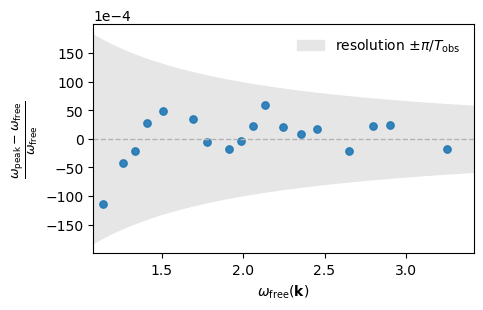

In [14]:
# frequency_confirmation_map.py
# Check frequency shifts in the interacting φ^4 evolution:
# compare peak frequencies of selected modes to the free spectrum.

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Use mathtext (no external LaTeX dependency)
mpl.rcParams["text.usetex"] = False

# ----------------------------
# Load data + metadata
# ----------------------------
meta = np.load("data/phi4_meta.npz", allow_pickle=True)
L          = float(meta["L"])
N          = int(meta["N"])
m          = float(meta["m"])
dt         = float(meta["dt"])
save_stride = int(meta["save_stride"])
lams       = np.array(meta["lams"], dtype=float)

data = np.load("data/phi4_snapshots.npz", allow_pickle=True)

# ----------------------------
# Pick which λ to analyse
# ----------------------------
lam = 1e-6   # <--- change this if you want a different coupling

key = f"lam_{lam:g}"
if key not in data:
    # fall back to exact meta key if formatter differs
    all_keys = [k for k in data.files if k.startswith("lam_")]
    raise KeyError(f"{key} not in snapshot file. Available keys: {all_keys}")

# X has shape (N^3, Tsave), entries q + i p at lattice sites
X = data[key]

# ----------------------------
# Grid / FFT helpers
# ----------------------------
a = L / N

kx = 2 * np.pi * np.fft.fftfreq(N, d=a)
ky = 2 * np.pi * np.fft.fftfreq(N, d=a)
kz = 2 * np.pi * np.fft.rfftfreq(N, d=a)   # rfft along z (non-negative)

KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="ij")
k2 = KX**2 + KY**2 + KZ**2

# free angular frequencies on the rfft grid
omega_free = np.sqrt(m * m + k2)


def rfftn3(u):
    """Real-to-complex 3D FFT on (N, N, N) grid."""
    return np.fft.rfftn(u, s=(N, N, N), axes=(0, 1, 2))


# ----------------------------
# Choose high-SNR Fourier modes to track
# ----------------------------
Tsave   = X.shape[1]
dt_save = dt * save_stride
t       = np.arange(Tsave) * dt_save
T_eff   = t[-1] - t[0] if Tsave > 1 else dt_save

# Use the first snapshot to score mode strengths
q0   = X[:, 0].real.reshape(N, N, N)
uk0  = rfftn3(q0)
p0   = np.abs(uk0) ** 2

# ignore DC mode
p0[0, 0, 0] = 0.0

M_pick   = 18                          # how many distinct |k| shells we want
flat_idx = np.argsort(p0.ravel())[::-1]
cand     = np.column_stack(np.unravel_index(flat_idx[:5 * M_pick], uk0.shape))


def unique_by_radius(indices, tol=0.05):
    """Select at most M_pick modes, separated in |k| by > tol."""
    keep = []
    radii = []
    for (i, j, k) in indices:
        r = np.sqrt(KX[i, j, k] ** 2 + KY[i, j, k] ** 2 + KZ[i, j, k] ** 2)
        if all(abs(r - rr) > tol for rr in radii):
            keep.append((i, j, k))
            radii.append(r)
        if len(keep) >= M_pick:
            break
    return keep


sel = unique_by_radius(cand, tol=0.08)

# ----------------------------
# Build time series for each selected mode
# ----------------------------
def extract_mode_series(X, sel):
    """Return dict[(i,j,k)] -> complex time series of Fourier coefficient of q(t)."""
    series = {idx: np.empty(Tsave, dtype=np.complex128) for idx in sel}
    for t_idx in range(Tsave):
        q_t  = X[:, t_idx].real.reshape(N, N, N)  # ensure real input to rfftn
        uk_t = rfftn3(q_t)
        for (i, j, k) in sel:
            series[(i, j, k)][t_idx] = uk_t[i, j, k]
    return series


series = extract_mode_series(X, sel)

# ----------------------------
# Peak-pick ω from temporal spectra
# ----------------------------
win   = np.hanning(Tsave)
omega = 2 * np.pi * np.fft.rfftfreq(Tsave, d=dt_save)  # angular frequency axis


def peak_omega(ts):
    """Return peak angular frequency of a complex time series."""
    if Tsave < 8:
        raise RuntimeError("Too few time samples to resolve peaks.")
    y   = (ts - ts.mean()) * win
    Y   = np.fft.rfft(y)
    psd = np.abs(Y) ** 2
    k0  = 1  # ignore near-DC bin
    kmax = np.argmax(psd[k0:]) + k0
    return float(omega[kmax])


points = []
for (i, j, k), ts in series.items():
    om_peak = peak_omega(ts)
    om_free = float(omega_free[i, j, k])
    frac    = (om_peak - om_free) / om_free
    points.append((om_free, frac))

points = np.array(points)   # shape (M_pick, 2)
xs = points[:, 0]
ys = points[:, 1]

# ----------------------------
# Resolution band (finite-time effect)
# ----------------------------
c_win  = 1.5   # Hann main-lobe fudge factor
domega = c_win * (1 * np.pi / T_eff) if T_eff > 0 else 0.0

x_band = np.linspace(xs.min() * 0.95, xs.max() * 1.05, 300)
y_band = domega / x_band   # fractional, symmetric

# ----------------------------
# Plot
# ----------------------------
pdftxtwidt = 6.17
figwidth   = 0.80 * pdftxtwidt
figheight  = 0.65 * figwidth

fig, ax = plt.subplots(figsize=(figwidth, figheight))

ax.fill_between(
    x_band, -y_band, y_band,
    color="0.9",
    label=r"resolution $\pm \pi/T_{\mathrm{obs}}$",
)
ax.axhline(0.0, color="0.7", ls="--", lw=1.0)
ax.scatter(xs, ys, s=28, alpha=0.9)

ax.set_xlabel(r"$\omega_{\mathrm{free}}(\mathbf{k})$")
ax.set_ylabel(
    r"$\frac{\omega_{\mathrm{peak}}-\omega_{\mathrm{free}}}{\omega_{\mathrm{free}}}$", fontsize = 13
)
ax.set_xlim(min(x_band), max(x_band))
# Compact y-axis: numbers × 10^{-4}
ax.ticklabel_format(axis="y", style="sci", scilimits=(-4, -4))
ax.yaxis.get_offset_text().set_size(10)

ax.legend(frameon=False)

fig.tight_layout()
fig.savefig("figures/frequency_confirmation_map.pdf", dpi=300, bbox_inches=None)
plt.show()


# Validation of the Analytic Construction of the Symplectic Basis $ \mathbf{V}^\star $

We now verify numerically that the analytically constructed symplectic basis $ \mathbf{V}^\star $
precisely reproduces the subspace and singular values obtained by direct numerical
singular value decomposition (SVD) of the complex snapshot matrix
\begin{align}
\mathbb{X}_c = Q_\alpha(t_j) + i\,P_\alpha(t_j).
\end{align}

The analytic singular values and left singular vectors are derived in closed form
from the shell-wise factorization
\begin{align}
\mathbb{X}_c^{(s)} = A^{(s)} T^{(s)\top}, \qquad
\sigma_{s,\pm}^2 \in \mathrm{spec}\!\big(\mathbb{M}_t^{(s)}\mathbb{M}_a^{(s)}\big),
\end{align}
where $ \mathbb{M}_t^{(s)} $ depends only on the time sampling and
$ \mathbb{M}_a^{(s)} $ only on the initial amplitudes and phases.

This test compares:
1. **Subspace angles** between the analytic and numerical singular subspaces, and  
2. **Singular values** from the analytic formula and numerical SVD.

All computations are performed in double precision, and agreement to machine precision
validates the analytic expressions derived in Appendix~\ref{app:analytic-Vstar}.


/scratch-local/slurm-job-tmp-11872320/ipykernel_189/2508000777.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  Svals.append(np.sqrt(float(lam[i])))


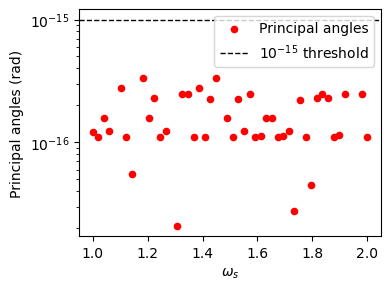

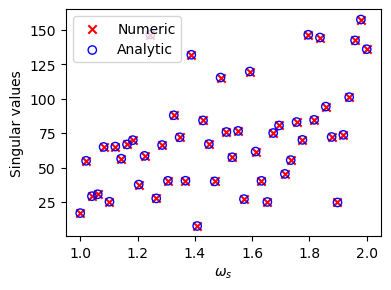

Relative projection error (analytic): 1.96e-16
Relative projection error (numeric):  2.32e-15


In [14]:
# ---------- utilities ----------
def group_shells(omega, tol=1e-12):
    w = np.asarray(omega)
    order = np.argsort(w)
    shells, shell_w = [], []
    start = 0
    for i in range(1, len(order)+1):
        if i == len(order) or abs(w[order[i]] - w[order[start]]) > tol:
            idx = order[start:i]
            shells.append(idx)
            shell_w.append(float(w[order[start]]))
            start = i
    return shells, shell_w

def snapshots_free(omega, T_max, T_steps, seed=0):
    rng = np.random.default_rng(seed)
    N = len(omega)
    t = np.linspace(0.0, T_max, T_steps)
    A = rng.standard_normal(N)
    B = rng.standard_normal(N)
    Xc = np.empty((N, T_steps), dtype=np.complex128)
    for k, w in enumerate(omega):
        c, s = np.cos(w*t), np.sin(w*t)
        Q = A[k]*c + B[k]*s
        P = -A[k]*w*s + B[k]*w*c
        Xc[k,:] = Q + 1j*P
    return Xc, t, A, B

def analytic_shell_S_and_U(Xc_shell, w, t, A_shell, B_shell):
    N_s, T = Xc_shell.shape
    c, s = np.cos(w*t), np.sin(w*t)
    a_plus = A_shell + 1j*w*B_shell
    a_minus = B_shell - 1j*w*A_shell
    A2 = np.column_stack([a_plus, a_minus])
    M_t = np.array([[np.dot(c,c), np.dot(c,s)],
                    [np.dot(s,c), np.dot(s,s)]], dtype=float)
    M_a = np.array([[np.vdot(A2[:,0], A2[:,0]), np.vdot(A2[:,0], A2[:,1])],
                    [np.vdot(A2[:,1], A2[:,0]), np.vdot(A2[:,1], A2[:,1])]],
                   dtype=np.complex128)
    M = M_t @ M_a
    lam, Z = eig(M)
    lam = np.real_if_close(lam)
    lam = np.clip(lam, 0, None)
    idx = np.argsort(lam)[::-1]
    lam, Z = lam[idx], Z[:, idx]
    Ucols, Svals = [], []
    for i in range(2):
        if lam[i] <= 0: continue
        u_raw = A2 @ Z[:, i]
        u_norm = norm(u_raw)
        if u_norm < 1e-14: continue
        Ucols.append(u_raw / u_norm)
        Svals.append(np.sqrt(float(lam[i])))
    if not Svals:
        return np.array([]), np.empty((N_s,0), dtype=np.complex128)
    return np.array(Svals), np.column_stack(Ucols)

def proj_err(U, X):
    if U.shape[1] == 0:
        return norm(X, 'fro'), 1.0
    R = U @ (U.conj().T @ X)
    e_abs = norm(X - R, 'fro')
    e_rel = e_abs / (norm(X, 'fro') + 1e-300)
    return e_abs, e_rel

# ---------- main experiment ----------
N = 50
omega = np.linspace(1.0, 2.0, N)
T_max, T_steps = 200.0, 2000

Xc, t, A0, B0 = snapshots_free(omega, T_max, T_steps, seed=0)
shells, shell_w = group_shells(omega, tol=1e-12)

U_cols, per_shell_info = [], []
for si, idxs in enumerate(shells):
    w = shell_w[si]
    Xs, A_s, B_s = Xc[idxs, :], A0[idxs], B0[idxs]
    S_pred, U_shell = analytic_shell_S_and_U(Xs, w, t, A_s, B_s)
    per_shell_info.append((si, w, S_pred, idxs, U_shell))
    if U_shell.shape[1] > 0:
        U_cols.append((idxs, U_shell))

U_blocks = []
for idxs, U_sh in U_cols:
    U_full = np.zeros((N, U_sh.shape[1]), dtype=np.complex128)
    U_full[idxs, :] = U_sh
    U_blocks.append(U_full)
U_analytic = np.concatenate(U_blocks, axis=1) if U_blocks else np.empty((N,0), dtype=np.complex128)

U_num, S_num_full, _ = svd(Xc, full_matrices=False)
r_analytic = U_analytic.shape[1]
U_num_r = U_num[:, :r_analytic]

# --- Compare shell by shell ---
from scipy.linalg import subspace_angles
freqs, angs, S_pred_list, S_num_list = [], [], [], []
col_cursor = 0
for (si, w, S_pred, idxs, U_shell) in per_shell_info:
    r_s = U_shell.shape[1]
    if r_s == 0: continue
    U_n_block = U_num_r[idxs, col_cursor:col_cursor+r_s]
    Qa, _ = np.linalg.qr(U_shell)
    Qn, _ = np.linalg.qr(U_n_block)
    ang = subspace_angles(Qa, Qn)
    freqs.extend([w]*r_s)
    angs.extend(list(ang))
    S_pred_list.extend(S_pred)
    S_num_s = svd(Xc[idxs,:], full_matrices=False, compute_uv=False)[:r_s]
    S_num_list.extend(S_num_s)
    col_cursor += r_s

# --- Compute projection error ---
e_abs_an, e_rel_an = proj_err(U_analytic, Xc)
e_abs_num, e_rel_num = proj_err(U_num_r, Xc)
# ---------- plotting (separate figures) ----------
# --- Figure geometry ---
pdftxtwidt = 6.17
figwidth = 0.65 * pdftxtwidt
figheight = 0.75 * figwidth



# (a) Principal angles
plt.figure(figsize=(figwidth, figheight))
plt.scatter(freqs, angs, color='r', s=20, label='Principal angles')
plt.axhline(1e-15, color='k', ls='--', lw=1, label=r'$10^{-15}$ threshold')
plt.yscale('log')
plt.xlabel(r'$\omega_s$')
plt.ylabel('Principal angles (rad)')
# plt.title('Analytic vs Numeric Subspace Angles')
plt.legend()
plt.tight_layout()
plt.savefig('figures/Vstar_angles.pdf', dpi=300)
plt.show()

# (b) Singular values

plt.figure(figsize=(figwidth, figheight))
plt.scatter(freqs, S_num_list, color='r', marker='x', label='Numeric')
plt.scatter(freqs, S_pred_list, facecolors='none', edgecolors='b', marker='o', label='Analytic')
plt.xlabel(r'$\omega_s$')
plt.ylabel('Singular values')
# plt.title('Analytic vs Numeric Singular Values')
plt.legend()
plt.tight_layout()
plt.savefig('figures/Vstar_singular_values.pdf', dpi=300)
plt.show()


print(f"Relative projection error (analytic): {e_rel_an:.2e}")
print(f"Relative projection error (numeric):  {e_rel_num:.2e}")


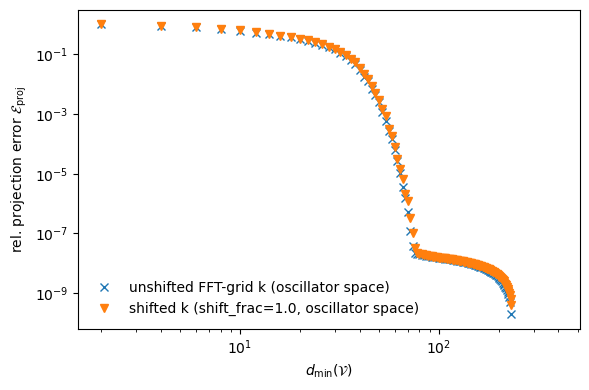

In [14]:

# ============================================================
# Shifted-k free field evolution (oscillator space only)
# Snapshot matrix X contains z_k(t) = q_k(t) + i p_k(t)
# ============================================================

def fft_int_freqs(N):
    """Integer mode indices in FFT convention: [0,1,...,N/2-1,-N/2,...,-1] for even N."""
    return (np.fft.fftfreq(N) * N).astype(int)

def build_mode_list(N):
    """All integer triplets (nx,ny,nz) in FFT ordering; length Nmodes = N^3."""
    n = fft_int_freqs(N)
    NX, NY, NZ = np.meshgrid(n, n, n, indexing="ij")
    return NX.ravel(), NY.ravel(), NZ.ravel()

def neg_fft_int(n, N):
    """Negation in FFT integer convention (Nyquist -N/2 is self-inverse for even N)."""
    if n == 0:
        return 0
    if (N % 2 == 0) and (n == -N // 2):
        return -N // 2
    return -n

def partner_index_map(nx, ny, nz, N):
    """Map each mode index i to its -mode index j in FFT integer convention."""
    key = np.stack([nx, ny, nz], axis=1)
    d = {tuple(key[i]): i for i in range(key.shape[0])}
    neg_of = np.empty(len(nx), dtype=int)
    for i in range(len(nx)):
        neg_trip = (
            neg_fft_int(int(nx[i]), N),
            neg_fft_int(int(ny[i]), N),
            neg_fft_int(int(nz[i]), N),
        )
        neg_of[i] = d[neg_trip]
    return neg_of

def make_shifted_k_vectors(L, N, nx, ny, nz, neg_of, rng, shift_frac=1.0):
    """
    Construct shifted wavevectors k' for each discrete mode n:
      k(n) = (2π/L) n,  then k'(n) = k(n) + δk with δk_i ∈ [-Δk/2, Δk/2],
      Δk = 2π/L. Enforce k'(-n) = -k'(n) for reality.
    """
    dk = 2 * np.pi / L
    Nm = len(nx)

    k = (2 * np.pi / L) * np.stack([nx, ny, nz], axis=1).astype(float)  # (Nm,3)
    kp = np.zeros_like(k)

    visited = np.zeros(Nm, dtype=bool)
    for i in range(Nm):
        if visited[i]:
            continue
        j = neg_of[i]
        visited[i] = True
        visited[j] = True

        # Self-conjugate modes (components in {0, -N/2}): keep unshifted
        if i == j:
            kp[i] = k[i]
            continue

        delta = (rng.random(3) - 0.5) * (shift_frac * dk)  # in [-shift_frac*dk/2, +]
        kp[i] = k[i] + delta
        kp[j] = -(k[i] + delta)  # enforce kp(-n) = -kp(n)

    return kp  # (Nm,3)

def make_real_initial_fourier_data(Nm, neg_of, rng, scale=1e-2):
    """
    Random ICs in mode space satisfying reality:
      q_{-k} = q_k^*, p_{-k} = p_k^*.
    Self-conjugate modes are purely real.
    """
    qk0 = np.zeros(Nm, dtype=np.complex128)
    pk0 = np.zeros(Nm, dtype=np.complex128)

    visited = np.zeros(Nm, dtype=bool)
    for i in range(Nm):
        if visited[i]:
            continue
        j = neg_of[i]
        visited[i] = True
        visited[j] = True

        if i == j:
            qk0[i] = scale * rng.standard_normal()
            pk0[i] = scale * rng.standard_normal()
        else:
            a = (rng.standard_normal() + 1j * rng.standard_normal()) / np.sqrt(2)
            b = (rng.standard_normal() + 1j * rng.standard_normal()) / np.sqrt(2)
            qk0[i] = scale * a
            pk0[i] = scale * b
            qk0[j] = np.conj(qk0[i])
            pk0[j] = np.conj(pk0[i])

    return qk0, pk0

def evolve_free_mode_snapshots(T_max, save_stride, qk0, pk0, w, dt=None):
    """
    Exact evolution per mode:
      q(t) = q0 cos(wt) + (p0/w) sin(wt)
      p(t) = p0 cos(wt) - (w q0) sin(wt)
    Snapshot matrix X has shape (Nmodes, Nsaves) with X = q + i p.
    """
    if dt is None:
        dt = 0.2 / w.max()  # only affects sampling density, not correctness

    steps = int(np.ceil(T_max / dt))
    dt = T_max / steps
    Nsaves = (steps + save_stride - 1) // save_stride

    Nm = len(w)
    X = np.empty((Nm, Nsaves), dtype=np.complex128)

    save_j = 0
    for n in range(steps):
        t = n * dt
        c = np.cos(w * t)
        s = np.sin(w * t)

        q_t = qk0 * c + (pk0 / w) * s
        p_t = pk0 * c - (w * qk0) * s

        if (n % save_stride == 0) and (save_j < Nsaves):
            X[:, save_j] = q_t + 1j * p_t
            save_j += 1

    return X[:, :save_j], dt

def rel_proj_error(X):
    """Relative tail energy after rank r from snapshot matrix X (complex)."""
    G = X.conj().T @ X
    G = 0.5 * (G + G.conj().T)
    evals, _ = np.linalg.eigh(G)
    evals = np.sort(np.clip(evals.real, 0, None))[::-1]  # = singular values^2
    tot = evals.sum() + 1e-300
    tail = np.cumsum(evals[::-1])[::-1]
    return np.sqrt(tail / tot)

# =========================
# Run the comparison test
# =========================
if __name__ == "__main__":
    L, N, m = 20.0, 14, 1.0
    scale_ic = 0.01
    seed = 123

    # Choose time < L_IR/c. With c=1 and L_IR~L, pick T_max_short < L.
    T_max_short = 1 * L
    save_stride = 2
    shift_frac = 1.0

    rng = np.random.default_rng(seed)

    # mode list + pairing
    nx, ny, nz = build_mode_list(N)
    neg_of = partner_index_map(nx, ny, nz, N)
    Nm = len(nx)

    # Same ICs for both runs
    qk0, pk0 = make_real_initial_fourier_data(Nm, neg_of, rng, scale=scale_ic)

    # Unshifted k and frequencies
    k_unshift = (2 * np.pi / L) * np.stack([nx, ny, nz], axis=1).astype(float)
    w_unshift = np.sqrt(m * m + np.sum(k_unshift * k_unshift, axis=1))
    X0, dt0 = evolve_free_mode_snapshots(T_max_short, save_stride, qk0, pk0, w_unshift, dt=None)
    err0 = rel_proj_error(X0)

    # Shifted k and frequencies
    rng_shift = np.random.default_rng(seed + 999)
    k_shift = make_shifted_k_vectors(L, N, nx, ny, nz, neg_of, rng_shift, shift_frac=shift_frac)
    w_shift = np.sqrt(m * m + np.sum(k_shift * k_shift, axis=1))
    Xs, dts = evolve_free_mode_snapshots(T_max_short, save_stride, qk0, pk0, w_shift, dt=None)
    errs = rel_proj_error(Xs)

    # Plot
    r0 = np.arange(1, len(err0) + 1)
    rs = np.arange(1, len(errs) + 1)
    d0 = 2 * r0
    ds = 2 * rs

    plt.figure(figsize=(6.0, 4.0))
    plt.semilogy(d0, err0, "x", label="unshifted FFT-grid k (oscillator space)")
    plt.semilogy(ds, errs, "v", label=f"shifted k (shift_frac={shift_frac}, oscillator space)")
    plt.xscale("log")
    plt.xlabel(r"$d_{\min}(\mathcal{V})$")
    plt.ylabel(r"rel. projection error $\mathcal{E}_{\rm proj}$")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()
